In [11]:
# Importing useful libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
os.chdir('..')
from DB_Connection.connection import PostgresConnection
from src.utils import missing_values_table, convert_bytes_to_megabytes

Connected to PostgreSQL database!
      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...  Youtube DL (Bytes)  Youtube UL (Bytes)  \
0  9.16456699548519E+015  ...          15854611.0           2501332.0   
1                L77566A  ...         

In [12]:
db = PostgresConnection(dbname='telecom', user='postgres', password='ab1234')
db.connect()

# Example query
query = "SELECT * FROM xdr_data"
result = db.execute_query(query)

# Convert the result to a Pandas DataFrame
df = pd.DataFrame(result, columns=[desc[0] for desc in db.cursor.description])
print(df.head())  # Display the first few rows of the DataFrame

# Close the connection when done
db.close_connection()

Connected to PostgreSQL database!
      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...  Youtube DL (Bytes)  Youtube UL (Bytes)  \
0  9.16456699548519E+015  ...          15854611.0           2501332.0   
1                L77566A  ...         

In [14]:
#Aggregate information per customer
# Treat missing values by replacing with the mean or mode
df['Avg RTT DL (ms)'] = df['Avg RTT DL (ms)'].fillna(df['Avg RTT DL (ms)'].mean())
df['Avg RTT UL (ms)'] = df['Avg RTT UL (ms)'].fillna(df['Avg RTT UL (ms)'].mean())
df['Avg Bearer TP DL (kbps)'] = df['Avg Bearer TP DL (kbps)'].fillna(df['Avg Bearer TP DL (kbps)'].mean())
df['Avg Bearer TP UL (kbps)'] = df['Avg Bearer TP UL (kbps)'].fillna(df['Avg Bearer TP UL (kbps)'].mean())
df['Handset Type'] = df['Handset Type'].fillna(df['Handset Type'].mode()[0])


In [15]:

# Aggregate the required information per customer
aggregated_df = df.groupby('MSISDN/Number').agg({'Avg Bearer TP DL (kbps)': 'mean',
                                                 'Avg RTT DL (ms)': 'mean',
                                                 'Handset Type': 'first',
                                                 'TCP DL Retrans. Vol (Bytes)': 'mean'})

In [17]:
# Compute and list top, bottom, and most frequent values

# TCP values
top_10_tcp = df['TCP DL Retrans. Vol (Bytes)'].nlargest(10)
bottom_10_tcp = df['TCP DL Retrans. Vol (Bytes)'].nsmallest(10)
most_frequent_tcp = df['TCP DL Retrans. Vol (Bytes)'].value_counts().head(10)

# RTT values
top_10_rtt = df['Avg RTT DL (ms)'].nlargest(10)
bottom_10_rtt = df['Avg RTT DL (ms)'].nsmallest(10)
most_frequent_rtt = df['Avg RTT DL (ms)'].value_counts().head(10)

# Throughput values
top_10_throughput = df['Avg Bearer TP DL (kbps)'].nlargest(10)
bottom_10_throughput = df['Avg Bearer TP DL (kbps)'].nsmallest(10)
most_frequent_throughput = df['Avg Bearer TP DL (kbps)'].value_counts().head(10)

In [18]:
# Compute and report

# Distribution of average throughput per handset type
throughput_distribution = df.groupby('Handset Type')['Avg Bearer TP DL (kbps)'].mean()

# Average TCP retransmission view per handset type
tcp_retransmission_view = df.groupby('Handset Type')['TCP DL Retrans. Vol (Bytes)'].mean()

# Print the results
print(" Aggregated information per customer:")
print(aggregated_df)

print("\n Top, bottom, and most frequent values:")
print("Top 10 TCP values:")
print(top_10_tcp)
print("Bottom 10 TCP values:")
print(bottom_10_tcp)
print("Most frequent TCP values:")
print(most_frequent_tcp)

print("\nTop 10 RTT values:")
print(top_10_rtt)
print("Bottom 10 RTT values:")
print(bottom_10_rtt)
print("Most frequent RTT values:")
print(most_frequent_rtt)

print("\nTop 10 Throughput values:")
print(top_10_throughput)
print("Bottom 10 Throughput values:")
print(bottom_10_throughput)
print("Most frequent Throughput values:")
print(most_frequent_throughput)

print("\n Distribution of average throughput per handset type:")
print(throughput_distribution)

print("\n - Average TCP retransmission view per handset type:")
print(tcp_retransmission_view)

 Aggregated information per customer:
               Avg Bearer TP DL (kbps)  Avg RTT DL (ms)  \
MSISDN/Number                                             
3.360100e+10                      37.0        46.000000   
3.360100e+10                      48.0        30.000000   
3.360100e+10                      48.0       109.795706   
3.360101e+10                     204.0        69.000000   
3.360101e+10                   20197.5        57.000000   
...                                ...              ...   
3.379000e+10                    9978.0        42.000000   
3.379000e+10                      68.0        34.000000   
3.197021e+12                       1.0       109.795706   
3.370000e+14                      11.0       109.795706   
8.823971e+14                       2.0       109.795706   

                                   Handset Type  TCP DL Retrans. Vol (Bytes)  
MSISDN/Number                                                                 
3.360100e+10     Huawei P20 Lite Hua

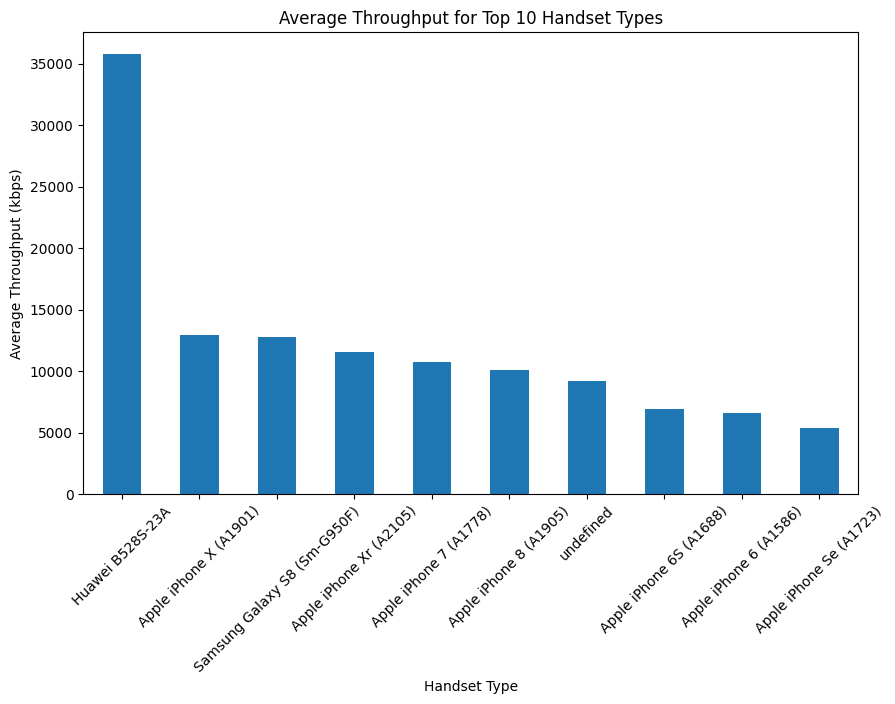

In [19]:
# Bar chart for average throughput per handset type
plt.figure(figsize=(10, 6))
top_10_handsets = df['Handset Type'].value_counts().head(10)
top_10_throughput = df[df['Handset Type'].isin(top_10_handsets.index)]
throughput_chart = top_10_throughput.groupby('Handset Type')['Avg Bearer TP DL (kbps)'].mean().sort_values(ascending=False)
throughput_chart.plot(kind='bar')
plt.title('Average Throughput for Top 10 Handset Types')
plt.xlabel('Handset Type')
plt.ylabel('Average Throughput (kbps)')
plt.xticks(rotation=45)
plt.show()

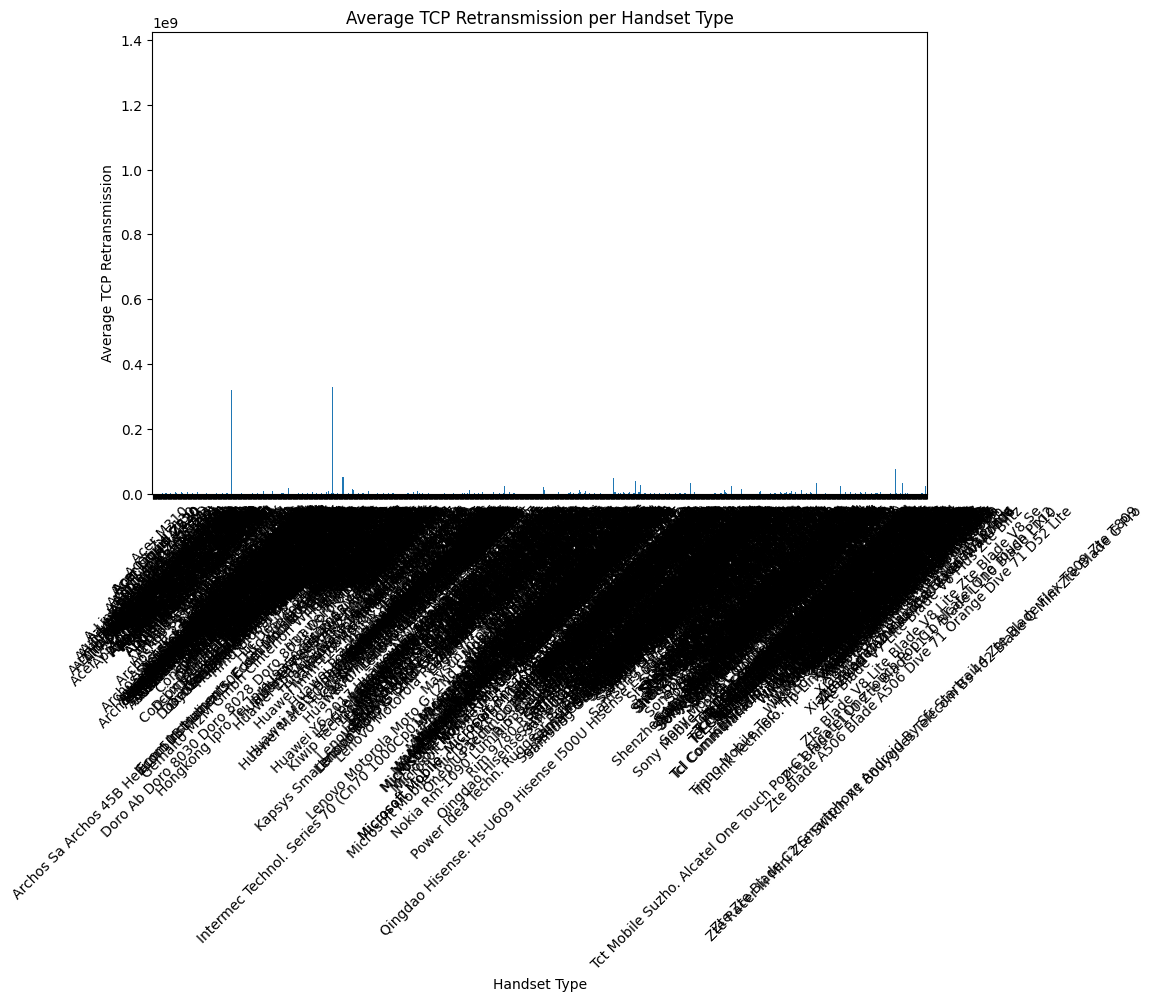

In [20]:
# Bar chart for average TCP retransmission per handset type
plt.figure(figsize=(10, 6))
tcp_retransmission_view.plot(kind='bar')
plt.title('Average TCP Retransmission per Handset Type')
plt.xlabel('Handset Type')
plt.ylabel('Average TCP Retransmission')
plt.xticks(rotation=45)
plt.show()

In [26]:
# Select relevant columns for clustering
features = ['Avg Bearer TP DL (kbps)', 'Avg RTT DL (ms)', 'TCP DL Retrans. Vol (Bytes)']

# Handle missing values: replace NaNs with column mean
df[features] = df[features].fillna(df[features].mean())

# Feature scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])

# Run k-means with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_features)



In [28]:
# Select only numeric columns from the DataFrame before aggregation
numeric_columns = df.select_dtypes(include=np.number).columns

# Group by 'Cluster' and calculate the mean for only the numeric columns
cluster_summary = df.groupby('Cluster')[numeric_columns].mean()

# Print the resulting summary
print(cluster_summary)

            Bearer Id    Start ms      End ms      Dur. (ms)          IMSI  \
Cluster                                                                      
0        1.013818e+19  499.202325  498.757406  104666.681152  2.082016e+14   
1        1.085332e+19  479.035857  529.123506   85475.741036  2.082016e+14   
2        9.114798e+18  536.455696  484.822785   55284.468354  2.082015e+14   

         MSISDN/Number          IMEI  Avg RTT DL (ms)  Avg RTT UL (ms)  \
Cluster                                                                  
0         4.190075e+10  4.841428e+13       101.228579        17.625065   
1         3.368723e+10  8.496737e+13       111.366534        38.912351   
2         3.367257e+10  4.667448e+13     16335.822785        21.797325   

         Avg Bearer TP DL (kbps)  ...  Youtube UL (Bytes)  Netflix DL (Bytes)  \
Cluster                           ...                                           
0                   13221.359389  ...        1.101005e+07        1.162799e+0

Visualize the clusters

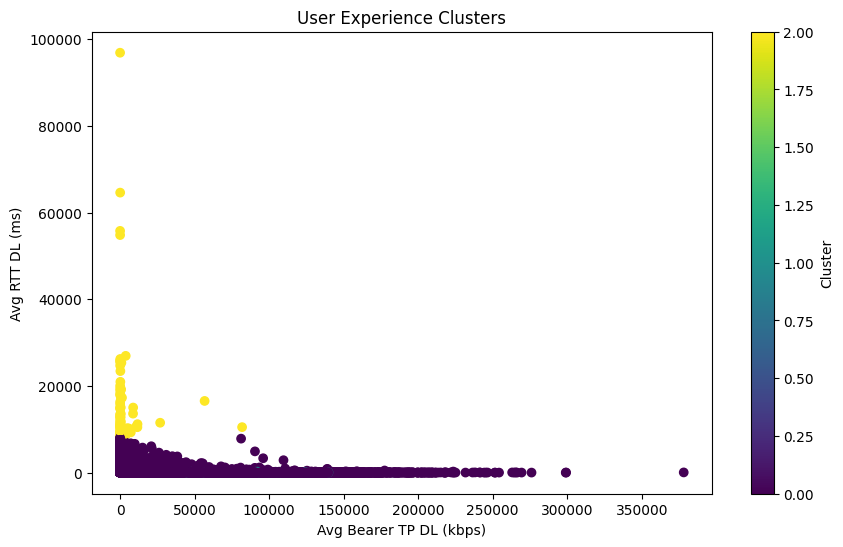

In [29]:
import matplotlib.pyplot as plt

# Scatter plot of two key metrics, colored by cluster
plt.figure(figsize=(10, 6))
plt.scatter(df['Avg Bearer TP DL (kbps)'], df['Avg RTT DL (ms)'], c=df['Cluster'], cmap='viridis')
plt.xlabel('Avg Bearer TP DL (kbps)')
plt.ylabel('Avg RTT DL (ms)')
plt.title('User Experience Clusters')
plt.colorbar(label='Cluster')
plt.show()